In [1]:
import pandas as pd
from MTL_dataset import MTLDataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from MTL_unetpp import MultiTaskUnetPlusPlus
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import albumentations as A
import torch
from torch.utils import data
import numpy as np
from PIL import Image
import os
from he_randaugment import randaugment
import torchvision.transforms as transforms
import cv2
import ast

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/abk9550/.local/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def color_image_to_mask_tisse(color_image):
    
        color_to_class_map = {
            (255, 255, 255): 0,
            (150, 200, 150): 1,
            (0, 255, 0): 2,
            (200, 0, 0): 3,
            (23, 172, 169): 2,
            (51, 0, 51): 2
        }
    
    
        color_array = np.array(color_image)
        mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)
        
        for color, class_value in color_to_class_map.items():
            is_color = np.all(color_array == color, axis=-1)
            if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
                mask[is_color] = class_value
                
        return mask

def color_image_to_mask(color_image):
    color_to_class_map = {
    (255, 255, 255): 0,    # Background
    (200, 0, 0): 1,        # nuclei_tumor
    (255, 0, 255): 2,      # TILs (lymphocytes and plasma cells)
    (150, 200, 150): 3,    # Other cells (histiocytes, stromal cells, etc.)
    (0, 255, 0): 3,
    (51, 0, 51): 3,
    (0, 128, 128): 3,
    (204, 204, 51): 3,
    (102, 26, 51): 3,
    (51, 51, 51): 3
    }

    color_array = np.array(color_image)
    unique_colors = np.unique(color_array.reshape(-1, color_array.shape[2]), axis=0)

    # Erstelle eine leere Maske für die Klassenzuordnung
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    for color in unique_colors:
        color_tuple = tuple(color)
        
        # Bestimme die Klasse, entweder durch explizite Zuordnung oder Standardklasse 3
        class_value = color_to_class_map.get(color_tuple, 3)
        
        is_color = np.all(color_array == color_tuple, axis=-1)
        
        if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
            mask[is_color] = class_value
    return mask



class_to_color_nuclei = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)       # Other cells
]

class_to_color_tissue = {
        0: (255, 255, 255),  # Background
        1: (150, 200, 150),  # tissue_stroma
        2: (0, 255, 0),      # other_tissues
        3: (200, 0, 0)       # tissue_tumor
    }


Processing ROIs:   0%|                                    | 0/4 [00:00<?, ?it/s]

../dataset/nuclei/training_set_metastatic_roi_014.png


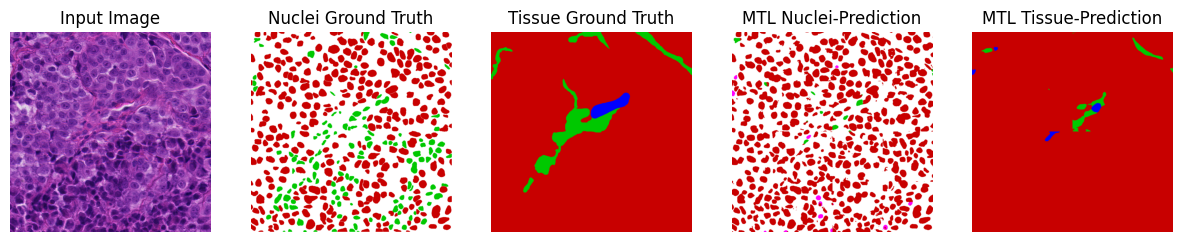

Processing ROIs:  25%|███████                     | 1/4 [00:02<00:08,  2.98s/it]

../dataset/nuclei/training_set_primary_roi_026.png


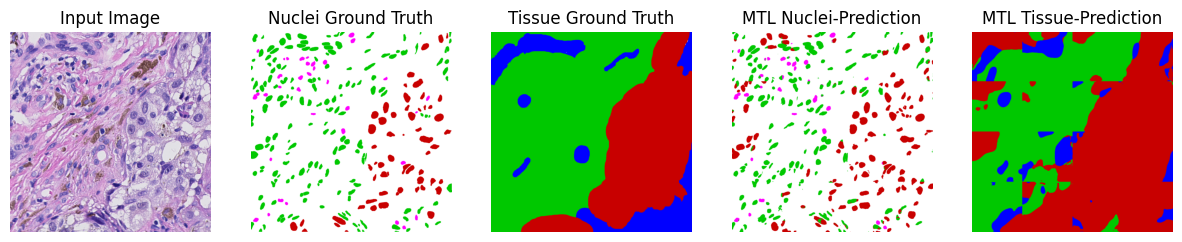

Processing ROIs:  50%|██████████████              | 2/4 [00:05<00:05,  2.70s/it]

../dataset/nuclei/training_set_primary_roi_020.png


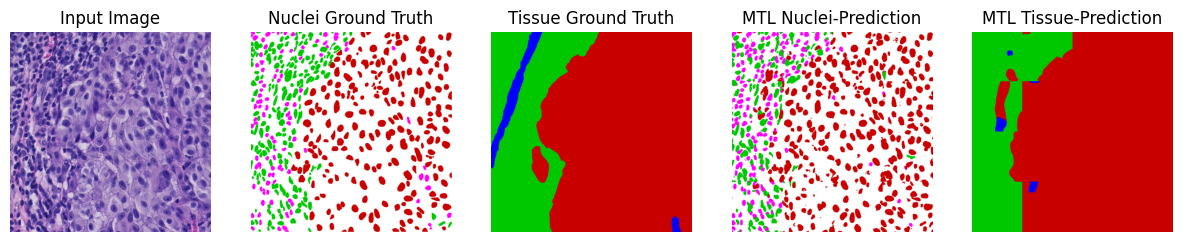

Processing ROIs:  75%|█████████████████████       | 3/4 [00:07<00:02,  2.61s/it]

../dataset/nuclei/training_set_metastatic_roi_081.png


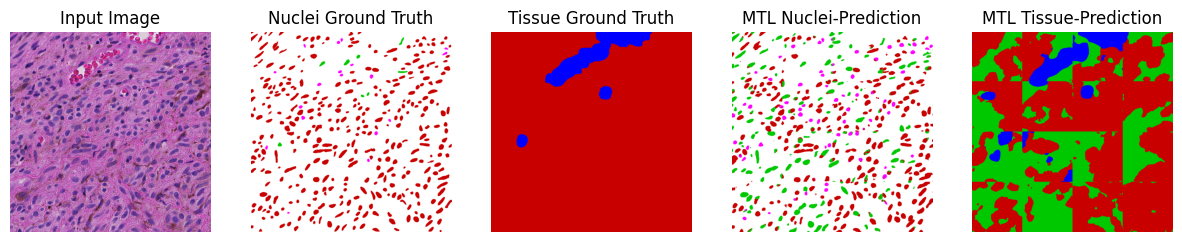

Processing ROIs: 100%|████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]


In [4]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
num_classes = 4
patch_size = 256


def preprocess(image_path):
    """Preprocess image for Extended Input and Dice models."""
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    rgb_image = normalize(image).unsqueeze(0).cuda()  # Add batch dimension    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = torch.tensor(gray_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda() / 255.0
    image = torch.cat((rgb_image, gray_image), dim=1)  # Combine RGB + Grayscale
    return image





def apply_color_mapping_tissue(mask):
    """Map class values in the mask to RGB colors."""
    class_colors = {
        0: (255, 255, 255),  # Background
        1: (0, 200, 0),    # stroma
        2: (0, 0, 255),      # other_tissues
        3: (200, 0, 0)       # tissue_tumor
    }

    # Leeres RGB-Bild erstellen
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Richtige Schleife für Mapping
    for k, color in class_colors.items():  # Korrektur: items() verwenden
        mask_rgb[mask == k] = np.array(color, dtype=np.uint8)  # Sicherstellen, dass die Farbe als NumPy-Array gesetzt wird

 #   print(f"Shape after mapping: {mask_rgb.shape}")  # Debugging-Ausgabe
    return mask_rgb





def apply_color_mapping_nuc(mask):
    """Map class values in the mask to RGB colors."""
    
    class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)   # Other cells
    ]
    
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, color in enumerate(class_colors):
        mask_rgb[mask == k] = color
    return mask_rgb

def process_patches(model, image, patch_size, num_classes):
    """Perform patch-wise inference on the image."""
    _, _, h, w = image.shape
    full_pred_nuc = np.zeros((h, w, num_classes), dtype=np.float32)
    full_pred_tissue = np.zeros((h, w, num_classes), dtype=np.float32)

    # Loop through the image in patches
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[:, :, y:y + patch_size, x:x + patch_size]

            # Pad patch if it exceeds boundaries
            pad_h = patch_size - patch.shape[2] if patch.shape[2] < patch_size else 0
            pad_w = patch_size - patch.shape[3] if patch.shape[3] < patch_size else 0
            if pad_h > 0 or pad_w > 0:
                patch = nn.functional.pad(patch, (0, pad_w, 0, pad_h), mode='constant', value=0)

            with torch.no_grad():
                t_output, n_output = model(patch)
                t_output = torch.sigmoid(t_output)
                n_output = torch.sigmoid(n_output)



        
            pred_patch_nuc = n_output.squeeze(0)# Shape: (num_classes, H, W)
            pred_patch_tissue = t_output.squeeze(0)  # Shape: (num_classes, H, W)

            # Transpose pred_patch to (H, W, num_classes)

            pred_patch_n = np.transpose(pred_patch_nuc.cpu().numpy(), (1, 2, 0))
            pred_patch_t = np.transpose(pred_patch_tissue.cpu().numpy(), (1, 2, 0))
    

            
            #pred_patch_n = np.transpose(pred_patch_nuc, (1, 2, 0))
            #pred_patch_t = np.transpose(pred_patch_tissue, (1, 2, 0))

            # Add prediction to full image
            
            full_pred_nuc[y:y + patch_size, x:x + patch_size, :] += pred_patch_n[:patch.shape[2], :patch.shape[3], :]

            full_pred_tissue[y:y + patch_size, x:x + patch_size, :] += pred_patch_t[:patch.shape[2], :patch.shape[3], :]


    # Convert logits to class predictions
    full_pred_nuc = np.argmax(full_pred_nuc, axis=-1)
    full_pred_tissue = np.argmax(full_pred_tissue, axis=-1)

    return full_pred_nuc, full_pred_tissue

def visualize_predictions(models, rois, base_path, g_path_n, g_path_t):
    """Visualize predictions."""
    
    for roi in tqdm(rois, desc="Processing ROIs"):
        image_path = os.path.join(base_path, roi + ".tif")
        ground_truth_path = os.path.join(str(g_path_n), str(roi) + ".png")
        print(ground_truth_path)
        
        ground_truth_path_tissue = os.path.join(str(g_path_t), str(roi) + ".png")
        ground_truth_rgb_tissue = Image.open(ground_truth_path_tissue).convert('RGB')  # Load as RGB
        ground_truth_rgb_tissue = color_image_to_mask_tisse(ground_truth_rgb_tissue)
        ground_truth_rgb_tissue = apply_color_mapping_tissue(ground_truth_rgb_tissue)

        
        ground_truth = Image.open(ground_truth_path).convert('RGB')  # Load as RGB
        ground_truth = color_image_to_mask(ground_truth)  # Convert to class mask   
        ground_truth_rgb_nuc = apply_color_mapping_nuc(ground_truth)
        
        # Process predictions for each model
        predictions = {}
        for model_name, model in models.items():

            image = preprocess(image_path)
            predictions[model_name] = process_patches(model, image, patch_size, num_classes)

        # Map masks to RGB for visualization
      
        #pred_rgb = {k: apply_color_mapping(v) for k, v in predictions.items()}
        #pred_rgb = {
        #    k: (
        #        apply_color_mapping_nuc(v[0]),       # Für full_pred_nuc
        #        apply_color_mapping_tissue(v[1])     # Für full_pred_tissue
        #    )
        #    for k, v in predictions.items()
        #}

        pred_rgb_nuc = {k: apply_color_mapping_nuc(v[0]) for k, v in predictions.items()}
        pred_rgb_tissue = {k: apply_color_mapping_tissue(v[1]) for k, v in predictions.items()}



        input_image = np.array(Image.open(image_path))


        
        # Erstellt eine Figure mit genügend Subplots für alle Modelle
        fig, axes = plt.subplots(1, len(models) * 2 + 3, figsize=(15, 7))
        
        # Zeige das Input-Image an
        axes[0].imshow(input_image)
        axes[0].set_title("Input Image")
        axes[0].axis("off")
        
        # Zeige die Ground-Truth-Masken an
        axes[1].imshow(ground_truth_rgb_nuc)
        axes[1].set_title("Nuclei Ground Truth")
        axes[1].axis("off")
        
        axes[2].imshow(ground_truth_rgb_tissue)
        axes[2].set_title("Tissue Ground Truth")
        axes[2].axis("off")
        
        # Anzahl der Modelle
        num_models = len(models)
        
        # Schleife für Nuclei-Predictions
        for idx, (model_name, pred) in enumerate(pred_rgb_nuc.items(), start=3):
            axes[idx].imshow(pred)
            axes[idx].set_title(f"{model_name} Nuclei-Prediction")
            axes[idx].axis("off")

        
        # Schleife für Tissue-Predictions (Startet nach den Nuclei-Predictions)
        for idx, (model_name, pred) in enumerate(pred_rgb_tissue.items(), start=3 + num_models):
            axes[idx].imshow(pred)
            axes[idx].set_title(f"{model_name} Tissue-Prediction")
            axes[idx].axis("off")
        plt.show()
 

# Load models
models = {
    "MTL":MultiTaskUnetPlusPlus(
        num_classes_task1_tissue=4,
        num_classes_task2_nuclei=4,
        in_channels=4,
        encoder_depth=4
    ).cuda()
}

# Load weights for each model
models["MTL"].load_state_dict(torch.load(r"../MTL/logs/MTL3/best_f1.pt"))
models["MTL"].eval()

# ROIs and paths
rois = [
    "training_set_metastatic_roi_014",
    "training_set_primary_roi_026",
    "training_set_primary_roi_020",
    "training_set_metastatic_roi_081"
]
base_path = r"../dataset/01_training_dataset_tif_ROIs"
ground_truth_path_nuc = r"../dataset/nuclei"
ground_truth_path_tissue = r"../dataset/tissue"

# Visualize predictions
visualize_predictions(models, rois, base_path, ground_truth_path_nuc, ground_truth_path_tissue)
